In [37]:
# %%
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.cluster import DBSCAN
from hdbscan import HDBSCAN, approximate_predict
from hdbscan.prediction import membership_vector
from sklearn.neighbors import NearestNeighbors
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical
from category_encoders import CatBoostEncoder
from copy import deepcopy
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical

pd.set_option('display.max_columns', None)

In [38]:
flight_data_train = pd.read_csv('./flight_data_train_ts_wx.csv')
flight_data_test = pd.read_csv('./flight_data_test_ts_wx.csv')

In [39]:
flight_data_train['scheduledoffblocktime'] = pd.to_datetime(flight_data_train['scheduledoffblocktime'])
flight_data_test['scheduledoffblocktime'] = pd.to_datetime(flight_data_test['scheduledoffblocktime'])

flight_data_train.sort_values(by='scheduledoffblocktime', inplace=True)
flight_data_test.sort_values(by='scheduledoffblocktime', inplace=True)

# %%
departdatetime = flight_data_train['scheduledoffblocktime'].dt

flight_data_train['depart_day'] = departdatetime.day
flight_data_train['depart_month'] = departdatetime.month
flight_data_train['depart_dayofweek'] = departdatetime.dayofweek
flight_data_train['depart_hour'] = departdatetime.hour
flight_data_train['depart_minute'] = departdatetime.minute
# Test
departdatetime = flight_data_test['scheduledoffblocktime'].dt
flight_data_test['depart_day'] = departdatetime.day
flight_data_test['depart_month'] = departdatetime.month
flight_data_test['depart_dayofweek'] = departdatetime.dayofweek
flight_data_test['depart_hour'] = departdatetime.hour
flight_data_test['depart_minute'] = departdatetime.minute

flight_data_train.drop(columns=['scheduledoffblocktime'], axis=1, inplace=True)
flight_data_test.drop(columns=['scheduledoffblocktime'], axis=1, inplace=True)

# %%
X_train = flight_data_train.drop(columns=['delay_in_secs', 'finalflightstatus'], axis=1)
X_test = flight_data_test.drop(columns=['delay_in_secs', 'finalflightstatus'], axis=1)

y_train = flight_data_train['finalflightstatus']
y_test = flight_data_test['finalflightstatus']

# %%
y_train = y_train.map({'On-Time': 0, 'Delayed':1})
y_test = y_test.map({'On-Time': 0, 'Delayed':1})

# %%
X_train




,traffictypecode,airlinecode_iata,destination_iata,aircraft_iata,isconnecting,publicgatenumber,aircraftterminal,tmpf,dwpf,relh,drct,sknt,alti,vsby,gust,skyc1,skyc2,skyl1,wxcodes,depart_day,depart_month,depart_dayofweek,depart_hour,depart_minute
0,PS,RA,KTM,332,0,F8,2,69.8,62.6,77.90,90.0,5.0,29.88,6.21,0,CAVOK,CAVOK,0.0,CC,8,3,6,4,25
1,PS,ET,ADD,77W,0,D6,1,69.8,62.6,77.90,90.0,5.0,29.88,6.21,0,CAVOK,CAVOK,0.0,CC,8,3,6,4,25
2,PS,6E,BOM,320,0,D7,1,69.8,62.6,77.90,90.0,5.0,29.88,6.21,0,CAVOK,CAVOK,0.0,CC,8,3,6,4,30
3,PS,EK,MLE,77W,0,C14,3,68.0,60.8,77.75,110.0,6.0,29.88,5.59,0,NSC,CAVOK,0.0,CC,8,3,6,4,35
4,PS,EK,CGK,77W,0,A8,3,68.0,60.8,77.75,110.0,6.0,29.88,5.59,0,NSC,CAVOK,0.0,CC,8,3,6,4,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197938,PS,PR,MNL,333,0,D2,1,100.4,73.4,42.30,120.0,13.0,29.35,6.21,0,CAVOK,CAVOK,0.0,CC,10,7,6,19,40
197941,PS,FZ,KHI,7S8,0,F9,2,100.4,73.4,42.30,120.0,13.0,29.35,6.21,0,CAVOK,CAVOK,0.0,CC,10,7,6,19,45
197942,PS,XY,RUH,32N,0,D8,1,100.4,73.4,42.30,120.0,13.0,29.35,6.21,0,CAVOK,CAVOK,0.0,CC,10,7,6,19,45
197940,PS,FZ,DOH,7M8,0,F8,2,100.4,73.4,42.30,120.0,13.0,29.35,6.21,0,CAVOK,CAVOK,0.0,CC,10,7,6,19,45


In [40]:
# %%
import pandas as pd
from category_encoders import CatBoostEncoder

high_cardinality_cols = ['airlinecode_iata', 'destination_iata', 'aircraft_iata', 'publicgatenumber']

catboost_encoder = CatBoostEncoder(cols=high_cardinality_cols, return_df=True)

X_train_encoded = catboost_encoder.fit_transform(X_train, y_train)

X_test_encoded = catboost_encoder.transform(X_test)

X_train = X_train_encoded
X_test = X_test_encoded

# %%
one_hot_column =  ['skyc1', 'skyc2', 'traffictypecode', 'aircraftterminal', 'wxcodes']

ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

encoded = ohe.fit_transform(X_train[one_hot_column])
ohe_new_columns = ohe.get_feature_names_out(one_hot_column)
encoded_df = pd.DataFrame(encoded, columns=ohe_new_columns)
X_train = pd.concat([X_train.drop(columns=one_hot_column), encoded_df], axis=1)

encoded = ohe.transform(X_test[one_hot_column])
encoded_df = pd.DataFrame(encoded, columns=ohe_new_columns)
X_test = pd.concat([X_test.drop(columns=one_hot_column), encoded_df], axis=1)



# %%
# numerical_cols = ['tmpf', 'dwpf', 'relh', 'drct', 'sknt', 'alti', 'vsby', 'skyl1']#, 'skyl2']

# # %%
# scaler = MinMaxScaler(feature_range=(0, 1))
# X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
# X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# %%
# Create cyclic features for month and day
# X_train['depart_month_sin'] = np.sin(2 * np.pi * X_train['depart_month'] / 12)
# X_train['depart_month_cos'] = np.cos(2 * np.pi * X_train['depart_month'] / 12)
# X_train['depart_day_sin'] = np.sin(2 * np.pi * X_train['depart_day'] / 31) 
# X_train['depart_day_cos'] = np.cos(2 * np.pi * X_train['depart_day'] / 31)
# X_train['depart_dayofweek_sin'] = np.sin(2 * np.pi * X_train['depart_dayofweek'] / 7) 
# X_train['depart_dayofweek_cos'] = np.cos(2 * np.pi * X_train['depart_dayofweek'] / 7)
# X_train['depart_minute_sin'] = np.sin(2 * np.pi * X_train['depart_minute'] / 1440) 
# X_train['depart_minute_cos'] = np.cos(2 * np.pi * X_train['depart_minute'] / 1440)

# X_test['depart_month_sin'] = np.sin(2 * np.pi * X_test['depart_month'] / 12)
# X_test['depart_month_cos'] = np.cos(2 * np.pi * X_test['depart_month'] / 12)
# X_test['depart_day_sin'] = np.sin(2 * np.pi * X_test['depart_day'] / 31)
# X_test['depart_day_cos'] = np.cos(2 * np.pi * X_test['depart_day'] / 31)
# X_test['depart_dayofweek_sin'] = np.sin(2 * np.pi * X_test['depart_dayofweek'] / 7) 
# X_test['depart_dayofweek_cos'] = np.cos(2 * np.pi * X_test['depart_dayofweek'] / 7)
# X_test['depart_minute_sin'] = np.sin(2 * np.pi * X_test['depart_minute'] / 1440)
# X_test['depart_minute_cos'] = np.cos(2 * np.pi * X_test['depart_minute'] / 1440)

# # Drop original features
# X_train = X_train.drop(['depart_month', 'depart_day', 'depart_minute', 'depart_dayofweek'], axis=1)
# X_test = X_test.drop(['depart_month', 'depart_day', 'depart_minute', 'depart_dayofweek'], axis=1)

/home/abdussaboor/.virtualenvs/mlr570-project/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [41]:
X_train.describe()

,airlinecode_iata,destination_iata,aircraft_iata,isconnecting,publicgatenumber,tmpf,dwpf,relh,drct,sknt,alti,vsby,gust,skyl1,depart_day,depart_month,depart_dayofweek,depart_hour,depart_minute,skyc1_CAVOK,skyc1_FEW,skyc1_NSC,skyc1_OVC,skyc1_SCT,skyc1_VV,skyc2_CAVOK,skyc2_FEW,skyc2_NSC,skyc2_SCT,traffictypecode_PE,traffictypecode_PS,aircraftterminal_1,aircraftterminal_2,aircraftterminal_3,wxcodes_-RA,wxcodes_-SHRA,wxcodes_-SS,wxcodes_-TSRA,wxcodes_BCFG,wxcodes_BLDU,wxcodes_BR,wxcodes_CC,wxcodes_DU,wxcodes_FG,wxcodes_HZ,wxcodes_SHRA,wxcodes_TS,wxcodes_TSRA,wxcodes_VCFG
count,1.979440e+05,1.979440e+05,1.979440e+05,1.979440e+05,1.979440e+05,1.979440e+05,1.979440e+05,1.979440e+05,1.979440e+05,1.979440e+05,1.979440e+05,1.979440e+05,1.979440e+05,1.979440e+05,1.979440e+05,1.979440e+05,1.979440e+05,1.979440e+05,1.979440e+05,1.979440e+05,1.979440e+05,1.979440e+05,1.979440e+05,1.979440e+05,1.979440e+05,1.979440e+05,1.979440e+05,1.979440e+05,1.979440e+05,1.979440e+05,1.979440e+05,1.979440e+05,1.979440e+05,1.979440e+05,1.979440e+05,1.979440e+05,1.979440e+05,1.979440e+05,1.979440e+05,1.979440e+05,1.979440e+05,1.979440e+05,1.979440e+05,1.979440e+05,1.979440e+05,1.979440e+05,1.979440e+05,1.979440e+05,1.979440e+05
mean,-4.594707e-17,1.167343e-16,-3.991652e-16,-3.528591e-17,-4.175440e-16,1.732205e-15,-7.351531e-17,-8.930962e-17,1.326722e-16,-9.189414e-18,9.056168e-15,6.363669e-16,1.170214e-17,-2.239920e-17,-1.361182e-16,-1.947007e-16,7.121796e-17,-5.233659e-17,6.443359e-17,-2.096335e-16,-1.148677e-18,-8.557642e-17,3.796018e-18,-1.292261e-17,-1.170214e-17,1.500172e-15,-4.738292e-18,3.508849e-18,-2.476834e-18,7.538191e-17,-9.677602e-17,1.424359e-16,-1.399950e-17,3.876784e-17,-1.636864e-17,-5.743384e-19,-1.651223e-18,-5.420319e-18,1.184573e-18,1.435846e-19,2.685032e-17,-8.155605e-17,-5.111612e-17,2.139410e-17,-1.435846e-17,1.489690e-18,4.235746e-18,4.397278e-18,-2.198639e-18
std,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00
min,-2.290692e+00,-2.244957e+00,-3.504643e+00,-1.974559e-01,-3.397208e+00,-2.498065e+00,-4.198529e+00,-2.614783e+00,-2.121699e+00,-1.897066e+00,-2.538005e+00,-5.835299e+00,-6.350183e-02,-3.216745e-01,-1.646857e+00,-1.454478e+00,-1.563164e+00,-1.717735e+00,-1.483940e+00,-1.560079e+00,-2.641748e-01,-4.781729e-01,-8.705444e-03,-1.652067e-01,-4.488564e-02,-2.784333e+01,-3.235498e-02,-8.104286e-03,-1.077998e-02,-1.828947e-01,-3.903788e+00,-4.955060e-01,-5.760358e-01,-1.079046e+00,-4.488564e-02,-1.030058e-02,-5.025963e-03,-1.605351e-02,-2.513744e-02,-2.688771e-02,-4.178469e-02,-4.435913e+00,-1.375393e-01,-5.132178e-02,-1.461567e-01,-5.946830e-03,-1.946892e-02,-1.123896e-02,-9.536408e-03
25%,-5.737963e-01,-6.815594e-01,-8.276712e-01,-1.974559e-01,-8.062353e-01,-7.915660e-01,-6.005570e-01,-7.135499e-01,-8.759620e-01,-7.825475e-01,-8.927768e-01,4.355782e-01,-6.350183e-02,-3.216745e-01,-8.511622e-01,-8.903465e-01,-1.061412e+00,-6.327390e-01,-9.201471e-01,-1.560079e+00,-2.641748e-01,-4.781729e-01,-8.705444e-03,-1.652067e-01,-4.488564e-02,3.591525e-02,-3.235498e-02,-8.104286e-03,-1.077998e-02,-1.828947e-01,2.561615e-01,-4.955060e-01,-5.760358e-01,-1.079046e+00,-4.488564e-02,-1.030058e-02,-5.025963e-03,-1.605351e-02,-2.513744e-02,-2.688771e-02,-4.178469e-02,2.254327e-01,-1.375393e-01,-5.132178e-02,-1.461567e-01,-5.946830e-03,-1.946892e-02,-1.123896e-02,-9.536408e-03
50%,-3.128124e-01,-1.376702e-01,-4.423116e-02,-1.974559e-01,1.304806e-01,-1.588480e-02,5.361966e-

In [42]:
from sklearn.mixture import GaussianMixture

# Define the number of components for GMM
n_components = 5

# Initialize and fit the GMM model
gmm = GaussianMixture(n_components=n_components, random_state=42)
gmm.fit(X_train)

# Predict the cluster for each sample in the training set
# X_train['gmm_cluster'] = 
pd.Series(gmm.predict(X_train)).value_counts()

# Predict the cluster for each sample in the test set
# X_test['gmm_cluster'] = gmm.predict(X_test)


0    99534
3    52588
2    26121
1    19356
4      345
Name: count, dtype: int64

In [43]:
# from sklearn.metrics import silhouette_score
# import matplotlib.pyplot as plt

# # Define the range for the number of components
# n_components_range = range(2, 21)

# # Initialize lists to store the number of components and corresponding silhouette scores
# silhouette_scores = []

# # Iterate over the range of components
# for n_components in n_components_range:
#     # Initialize and fit the GMM model
#     gmm = GaussianMixture(n_components=n_components, random_state=42)
#     gmm.fit(X_train)
    
#     # Predict the cluster for each sample in the training set
#     cluster_labels = gmm.predict(X_train)
    
#     # Calculate the silhouette score
#     silhouette_avg = silhouette_score(X_train, cluster_labels)
#     silhouette_scores.append(silhouette_avg)

# # Plot the silhouette scores for each number of components
# plt.figure(figsize=(10, 6))
# plt.plot(n_components_range, silhouette_scores, marker='o')
# plt.title('Silhouette Scores for Different Numbers of Components')
# plt.xlabel('Number of Components')
# plt.ylabel('Silhouette Score')
# plt.grid(True)
# plt.show()

# # Find the best number of components based on the highest silhouette score
# best_n_components = n_components_range[silhouette_scores.index(max(silhouette_scores))]
# print(f"Best number of components: {best_n_components}")
# print(f"Best silhouette score: {max(silhouette_scores)}")

# # # Refit the GMM model with the best number of components
# # gmm = GaussianMixture(n_components=best_n_components, random_state=42)
# # gmm.fit(X_train)

# # # Predict the cluster for each sample in the training set
# # X_train['gmm_cluster'] = gmm.predict(X_train)

# # # Predict the cluster for each sample in the test set
# # X_test['gmm_cluster'] = gmm.predict(X_test)



In [66]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

kmeans = KMeans(n_clusters=18, random_state=42)
kmeans.fit(X_train)

# Predict the cluster for each sample in the training set
cluster_labels_train = kmeans.predict(X_train)

# Predict the cluster for each sample in the test set
cluster_labels_test = kmeans.predict(X_test)



In [67]:
pd.Series(cluster_labels_train).value_counts()


2     30828
12    28664
17    27448
1     24296
0     21694
6     19594
9     12438
10    12406
5      6147
7      5046
16     4850
13     3672
4       398
3       345
14       75
8        23
15       15
11        5
Name: count, dtype: int64

In [ ]:
# import scipy.cluster.hierarchy as sch

# # Create a dendrogram
# plt.figure(figsize=(10, 7))
# dendrogram = sch.dendrogram(sch.linkage(X_train, method='ward'))
# plt.title('Dendrogram')
# plt.xlabel('Samples')
# plt.ylabel('Euclidean distances')
# plt.show()


In [59]:
from sklearn.decomposition import PCA

# Initialize PCA with the number of components you want to keep
pca = PCA(n_components=2)

# Fit and transform the training data
X_train_pca = pca.fit_transform(X_train)

# Transform the test data
X_test_pca = pca.transform(X_test)


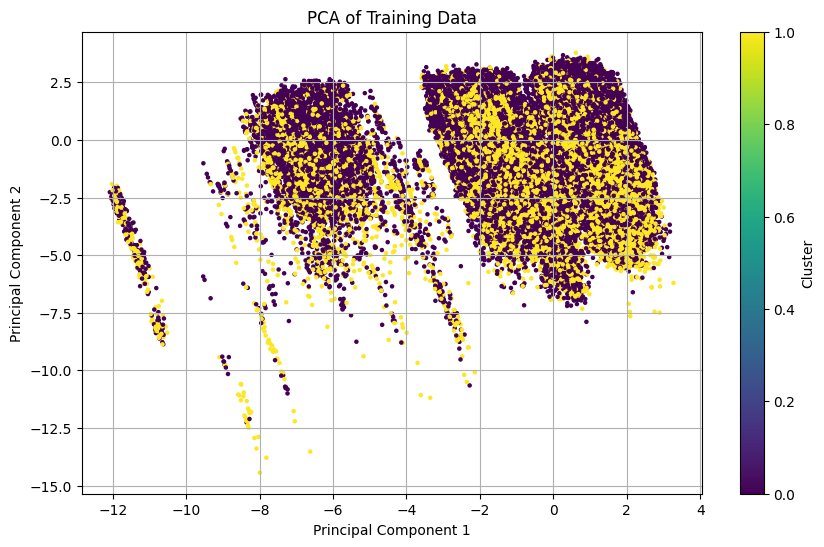

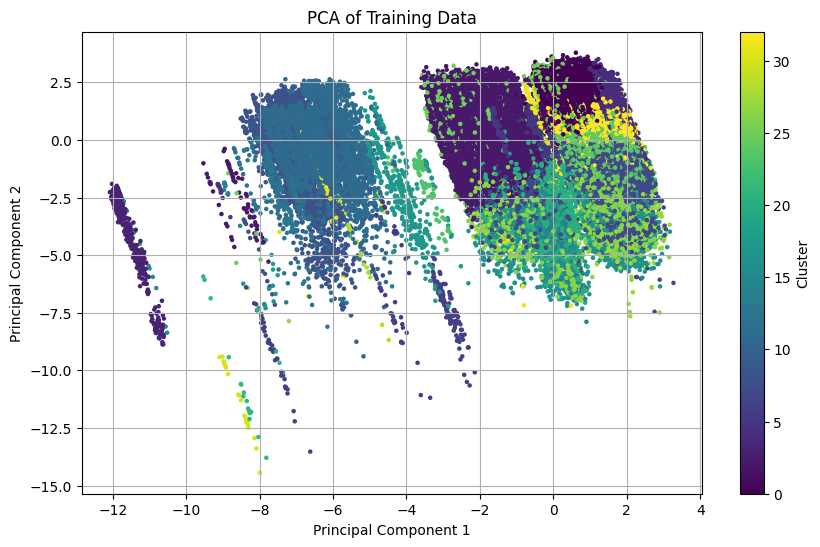

In [60]:
# Plot the PCA results
plt.figure(figsize=(10, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis', s=5)
plt.title('PCA of Training Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

# Plot the PCA results
plt.figure(figsize=(10, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=cluster_labels_train, cmap='viridis', s=5)
plt.title('PCA of Training Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

In [68]:
from sklearn.manifold import TSNE

# Initialize TSNE with the number of components you want to keep
tsne = TSNE(n_components=2, random_state=42)

# Fit and transform the training data
X_train_tsne = tsne.fit_transform(X_train)

# Transform the test data
X_test_tsne = tsne.fit_transform(X_test)


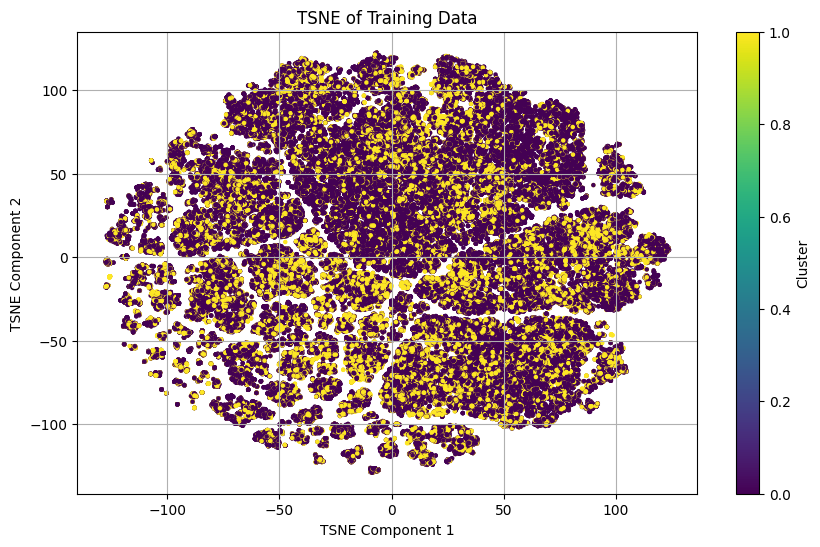

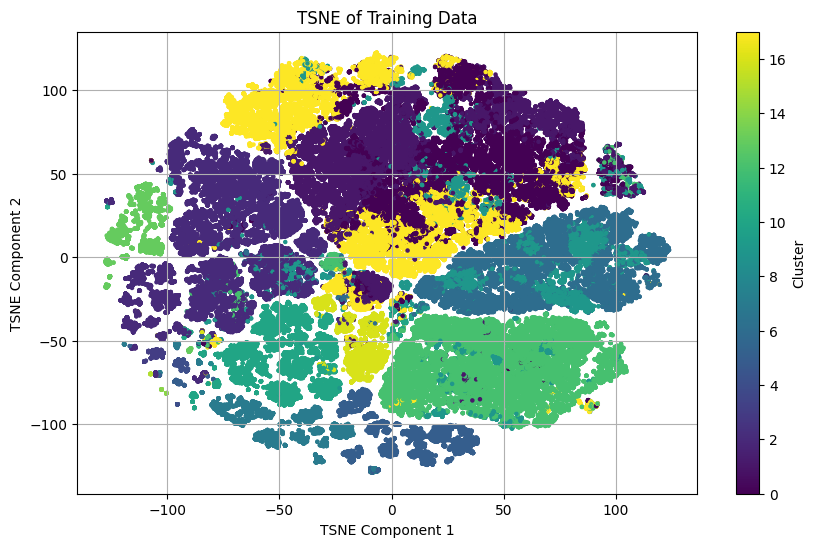

In [69]:

plt.figure(figsize=(10, 6))
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train, cmap='viridis', s=5)
plt.title('TSNE of Training Data')
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

# Plot the TSNE results
plt.figure(figsize=(10, 6))
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=cluster_labels_train, cmap='viridis', s=5)
plt.title('TSNE of Training Data')
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

In [45]:
import umap
reducer = umap.UMAP(n_neighbors=15, n_components=2, random_state=42)
X_train_umap = reducer.fit_transform(X_train)
X_test_umap = reducer.transform(X_test)


/home/abdussaboor/.virtualenvs/mlr570-project/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/abdussaboor/.virtualenvs/mlr570-project/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


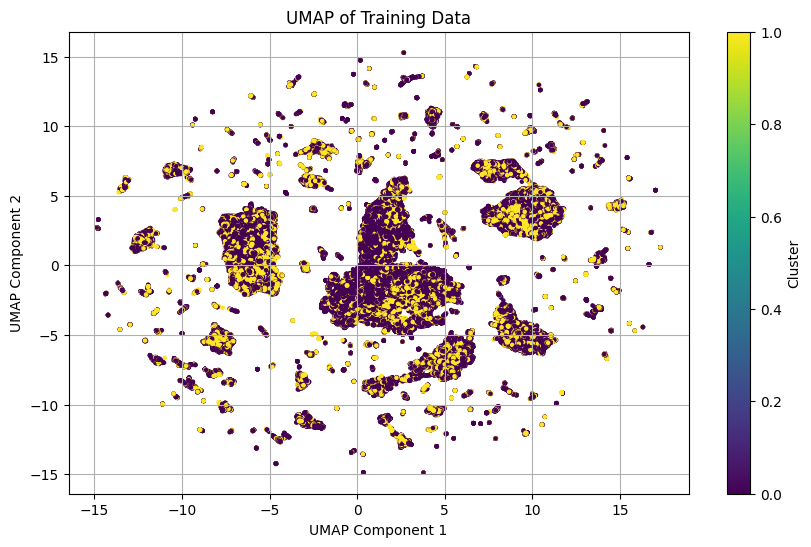

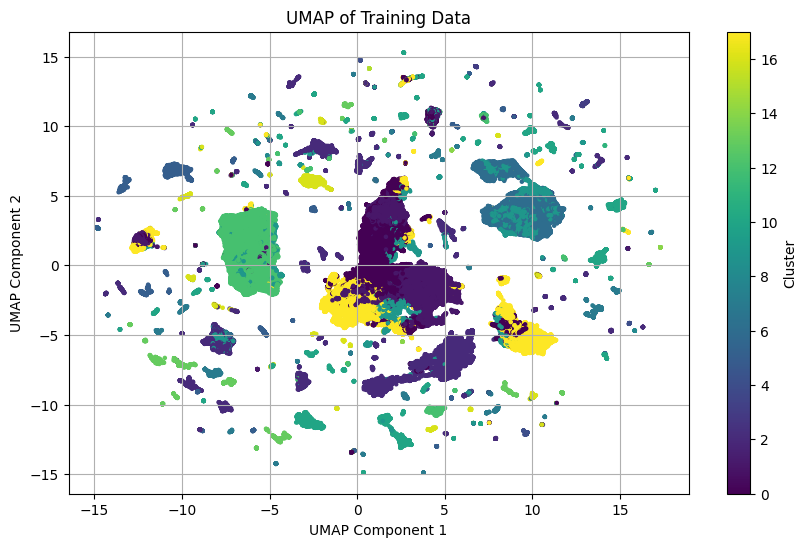

In [70]:
plt.figure(figsize=(10, 6))
plt.scatter(X_train_umap[:, 0], X_train_umap[:, 1], c=y_train, cmap='viridis', s=5)
plt.title('UMAP of Training Data')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

# Plot the UMAP results
plt.figure(figsize=(10, 6))
plt.scatter(X_train_umap[:, 0], X_train_umap[:, 1], c=cluster_labels_train, cmap='viridis', s=5)
plt.title('UMAP of Training Data')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

# Plot the UMAP results
plt.figure(figsize=(10, 6))
plt.scatter(X_train_umap[:, 0], X_train_umap[:, 1], c=cluster_train, cmap='viridis', s=5)
plt.title('UMAP of Training Data')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()


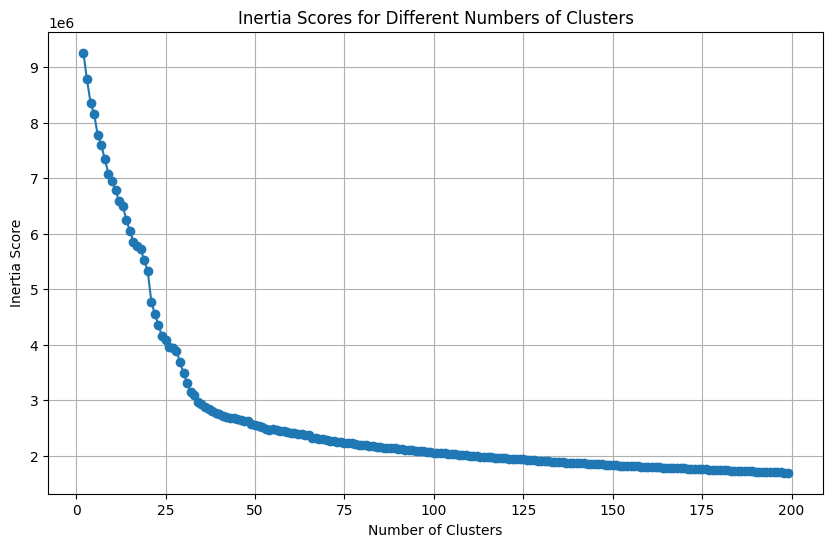

In [49]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Define the range for the number of clusters
k_range = range(2, 200)

# Initialize lists to store the number of clusters and corresponding inertia scores
inertia_scores = []

# Iterate over the range of clusters
for k in k_range:
    # Initialize and fit the KMeans model
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_train)
    
    # Calculate the inertia score
    inertia_score = kmeans.inertia_
    inertia_scores.append(inertia_score)

# Plot the inertia scores for each number of clusters
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia_scores, marker='o')
plt.title('Inertia Scores for Different Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia Score')
plt.grid(True)
plt.show()

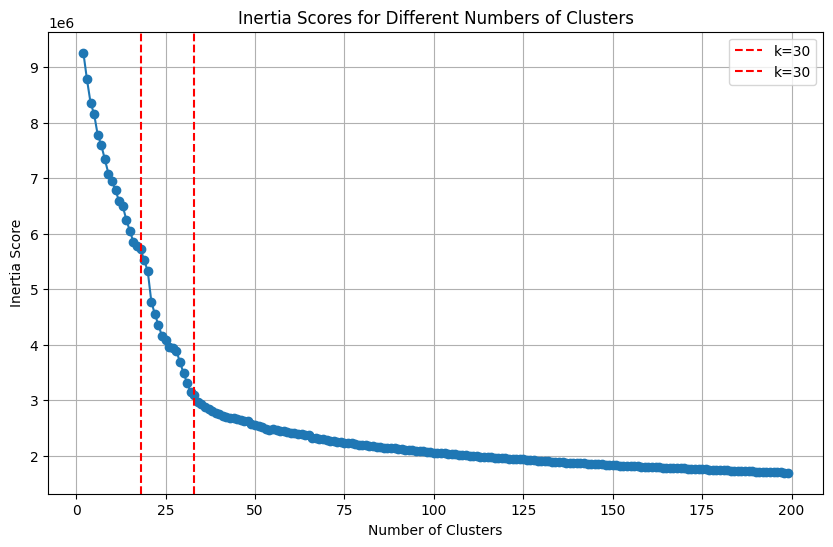

In [65]:
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia_scores, marker='o')
plt.axvline(x=18, color='r', linestyle='--', label='k=30')
plt.axvline(x=33, color='r', linestyle='--', label='k=30')
plt.title('Inertia Scores for Different Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia Score')
plt.grid(True)
plt.legend()
plt.show()

In [71]:
hdbscan_model = HDBSCAN(
    min_cluster_size=3000,      # Increase to avoid microclusters
    min_samples=10,              # Lower to reduce noise points
    cluster_selection_epsilon=0.5,  # Increase to reduce noise points
    cluster_selection_method='eom',  # 'eom' tends to produce more balanced clusters
    prediction_data=True,
    core_dist_n_jobs=-1
)
clusters_train = pd.DataFrame(hdbscan_model.fit_predict(X_train), columns=['Cluster'])
clusters_train['Cluster'].value_counts()